In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

# CT scan acquisition simulation using [gVXR](https://gvirtualxray.sourceforge.io/) and CT reconstruction with [CIL](https://ccpi.ac.uk/cil/)

This example makes use of two open source libraries fro X-ray imaging. The first one is [gVXR](https://gvirtualxray.sourceforge.io/). It is used to simulate realistic radiographic images from a CAD model. This time **a JSON file is used to set the simulation parameters.** The JSON file format is relatively user friendly. It is much easier to describe the simulation parameters as no code is needed. The second one is [CIL](https://ccpi.ac.uk/cil/). It implements many CT reconstruction algorithms, including the well-known FDK. The details of the CT scan acquisition are given in the table below. Both FDK and SIRT (iterative method) reconstructions were performed. 

![Image comparison of the FDK and SIRT reconstructions](../results/dragon/comparison.png)

| Parameter | Value |
|-----------|-------|
| source-to-object distance (SOD) | 150 cm |
| object-to-detector distance (ODD) | 40 cm |
| source-to-detector distance (SDD) | 190 cm |
| detector resolution | 512 &times; 512 pixels |
| pixel pitch | 500 &times; 500 &mu;m |
| scintillator | 500 &mu;m of CsI|
| energy response of the detector | ![Plot of the energy response of the detector](../results/dragon/detector-energy_response.png) |
| detector impulse response | ![Plot of the detector impulse response](../results/dragon/detector-LSF.png) |
| tube anode material | tungsten |
| tube anode angle | 10&deg; |
| tube voltage | 160 kV |
| beam filtration | 1mm of Sn |
| tube exposure | 0.5 mAs |
| beam spectrum | ![Plot of the beam spectrum](../results/dragon/beam-spectrum.png) |
| sample geometry | ![](../results/dragon/wireframe.png) |
| sample material composition | Ti90Al6V4 |
| sample material density | 4.43 g/cm<sup>3</sup>|
| number of projection | 200 |
| first angle | 0&deg; |
| last angle | 360&deg; |
| number of flat images | 60 |

In [2]:
# Import packages
import os, time
import numpy as np

# Increase the font size in plots
import matplotlib
font = {'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt # Plotting

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3 import json2gvxr # Simulate X-ray images
from gvxrPython3.utils import visualise

# CT reconstruction using CIL
from gvxrPython3.JSON2gVXRDataReader import *

from cil.io import TIFFWriter
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.recon import FDK
from cil.optimisation.algorithms import SIRT
from cil.optimisation.functions import IndicatorBox
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.jupyter import islicer

Fri Aug 16 13:09:00 2024 (WW) Spekpy is not installed, try Xpecgen instead.
Fri Aug 16 13:09:00 2024 (WW) Xpecgen is not installed either.


SimpleGVXR 2.0.8 (2024-08-01T13:42:33) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.8 (2024-08-01T13:42:32) [Compiler: GNU g++] on Linux


In [3]:
def getRuntime(start, stop):
    return stop - start, "sec";

## Set the simulation parameters

In [4]:
# Initialise gVXR using our JSON file
json_fname = "../results/dragon.json"

# MS Windows
if os.name == "nt":
    json2gvxr.initGVXR(json_fname, renderer="EGL")
# MacOS
elif str(os.uname()).find("Darwin") >= 0:
    json2gvxr.initGVXR(json_fname, renderer="OPENGL")
# GNU/Linux
else:
    json2gvxr.initGVXR(json_fname, renderer="EGL")

Create an OpenGL context: 500x500


Fri Aug 16 13:09:01 2024 ---- Create window (ID: -1)
Fri Aug 16 13:09:01 2024 ---- Request a EGL context
Fri Aug 16 13:09:01 2024 ---- EGL client extensions:
Fri Aug 16 13:09:01 2024 ---- EGL_EXT_platform_base EGL_EXT_device_base EGL_EXT_device_enumeration EGL_EXT_device_query EGL_KHR_client_get_all_proc_addresses EGL_EXT_client_extensions EGL_KHR_debug EGL_KHR_platform_x11 EGL_EXT_platform_x11 EGL_EXT_platform_device EGL_MESA_platform_surfaceless EGL_EXT_explicit_device EGL_KHR_platform_wayland EGL_EXT_platform_wayland EGL_KHR_platform_gbm EGL_MESA_platform_gbm EGL_EXT_platform_xcb
Fri Aug 16 13:09:01 2024 ---- EGL clients supported by this host:
Fri Aug 16 13:09:01 2024 ---- 	- Surfaceless platform
Fri Aug 16 13:09:01 2024 ---- 	- X11 platform
Fri Aug 16 13:09:01 2024 ---- 	- Wayland platform
Fri Aug 16 13:09:01 2024 ---- 	- GBM platform
Fri Aug 16 13:09:01 2024 ---- 	- Device platform
Fri Aug 16 13:09:01 2024 ---- Initialise EGL
Fri Aug 16 13:09:01 2024 ---- Try to build an EGL disp

In [5]:
# Set up the detector
json2gvxr.initDetector(json_fname, verbose=0)

Set up the detector
	Detector position: [0.0, 400.0, 0.0, 'mm']
	Detector up vector: [0.0, 0.0, -1.0]
	Detector right vector: [-1.0, 0.0, 0.0]
	Number of pixels: [512, 512]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.5, 0.5, 'mm']
LSF: [0.0011069800239056349, 0.0012259900104254484, 0.0013652200577780604, 0.0015295400517061353, 0.0017253300175070763, 0.001961159985512495, 0.0022487000096589327, 0.0026041900273412466, 0.003050740109756589, 0.0036221600603312254, 0.004369390197098255, 0.005372089799493551, 0.006760119926184416, 0.00875640008598566, 0.011768239550292492, 0.016599329188466072, 0.024994460865855217, 0.04120158031582832, 0.0767488032579422, 0.1591169834136963, 0.24774515628814697, 0.1591169834136963, 0.0767488032579422, 0.04120158031582832, 0.024994460865855217, 0.016599329188466072, 0.011768239550292492, 0.00875640008598566, 0.006760119926184416, 0.005372089799493551, 0.004369390197098255, 0.0036221600603312254, 0.003050740109756589, 0.0026041900273412466, 0.00

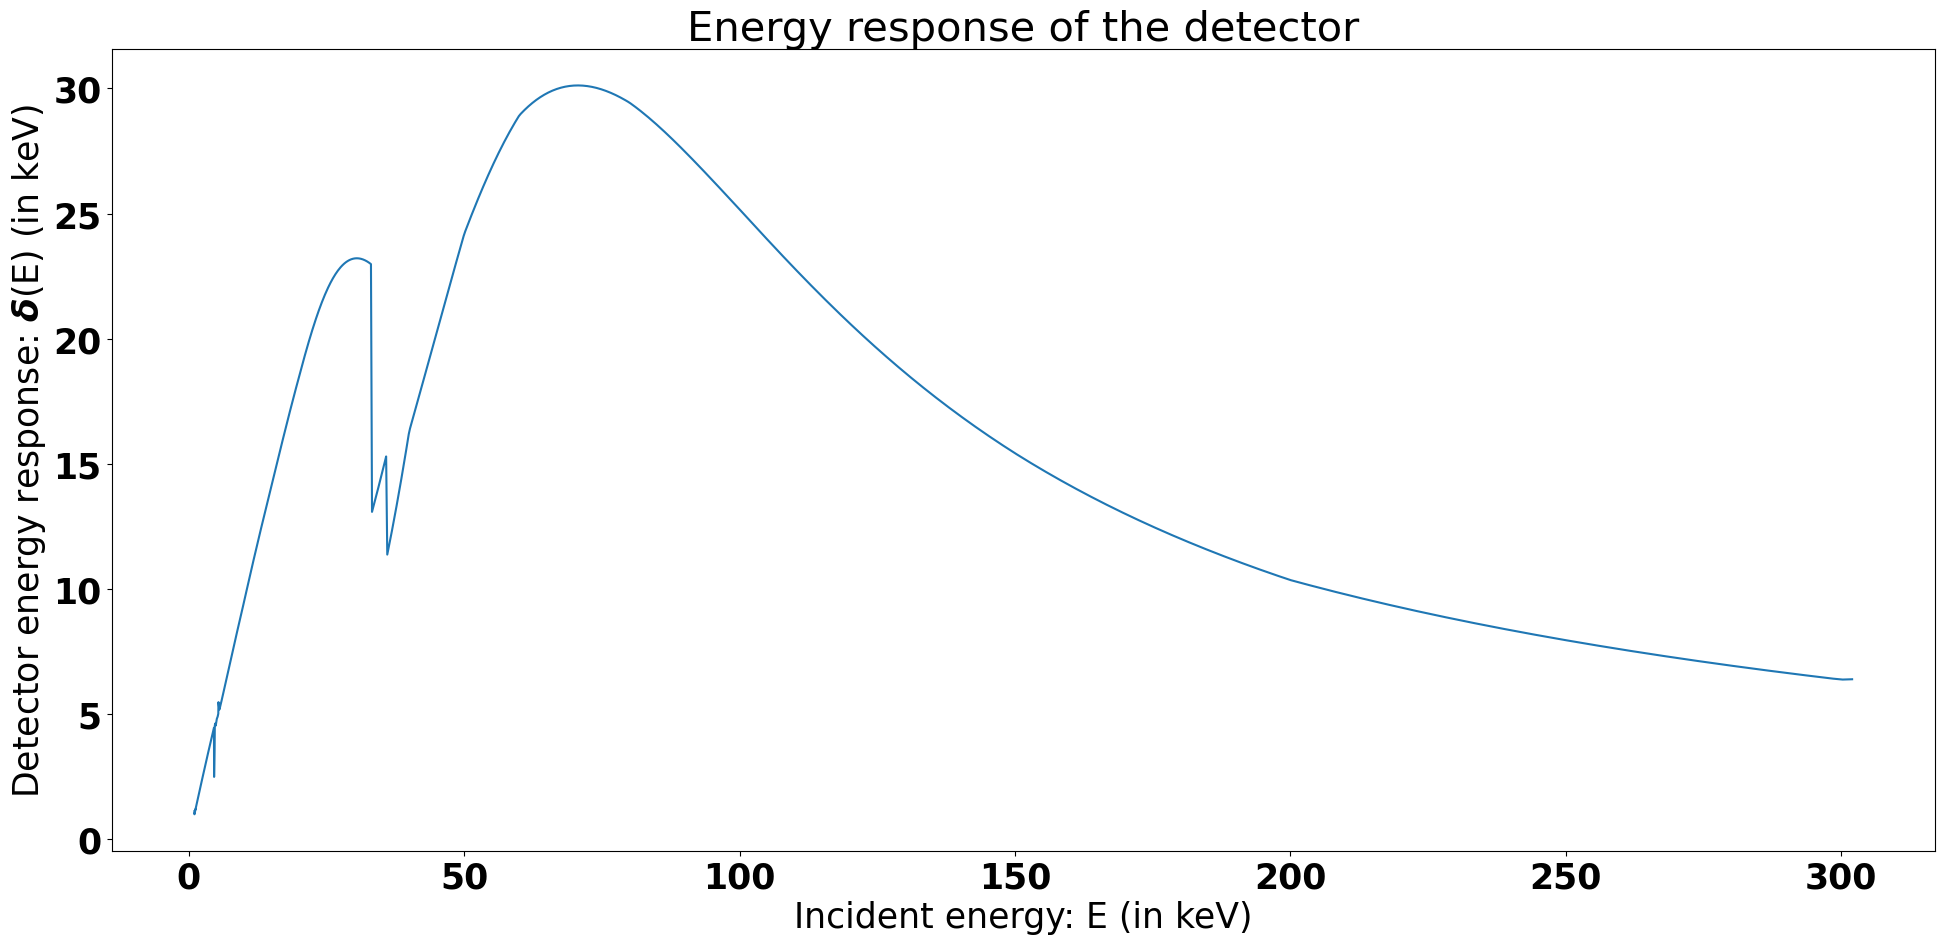

In [6]:
# Plot the energy response of the detector
detector_response = np.array(gvxr.getEnergyResponse("keV"))
plt.figure(figsize= (20,10))
plt.title("Energy response of the detector")
plt.plot(detector_response[:,0], detector_response[:,1])
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')
plt.tight_layout()
plt.savefig("../results/dragon/detector-energy_response.png", dpi=20)
plt.savefig("../results/dragon/detector-energy_response.pdf", dpi=600)

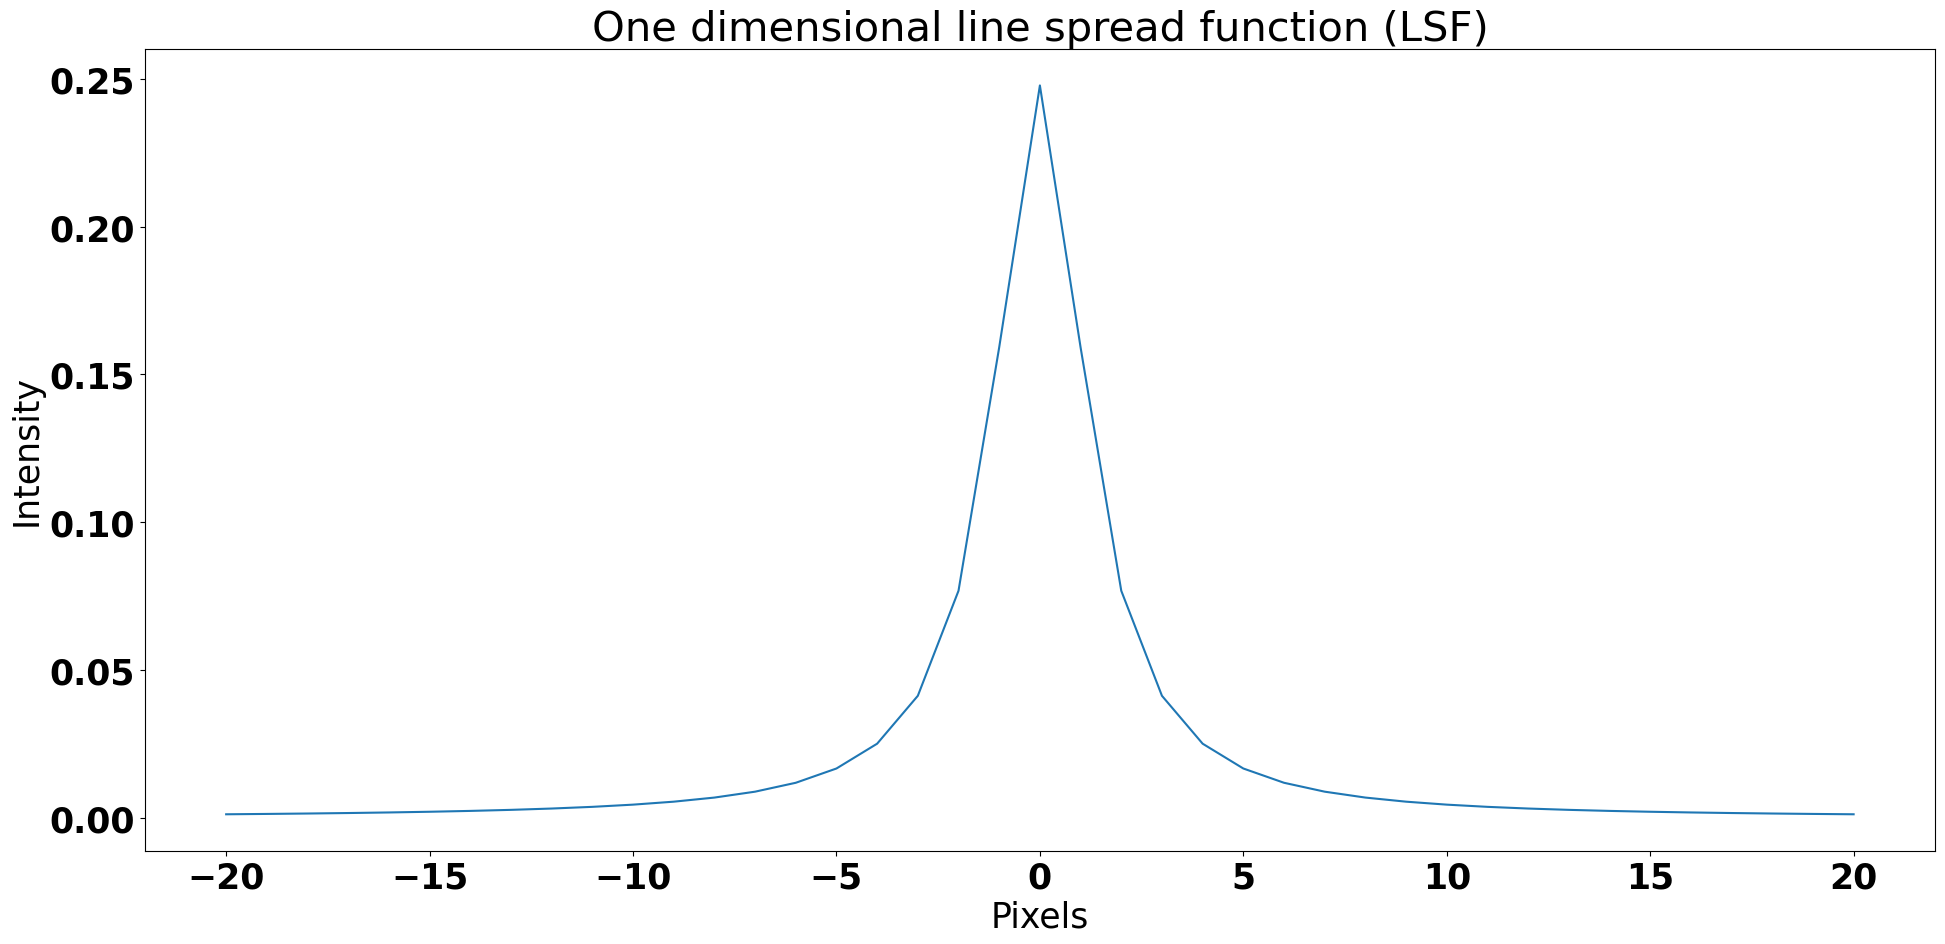

In [7]:
# Plot the energy response of the detector
lsf = np.array(gvxr.getLSF())
half_size = len(lsf) // 2
x = np.arange(-half_size, half_size + 1)

plt.figure(figsize= (20,10))
plt.title("One dimensional line spread function (LSF)")
plt.plot(x, lsf)
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.tight_layout()
plt.savefig("../results/dragon/detector-LSF.png", dpi=20)
plt.savefig("../results/dragon/detector-LSF.pdf", dpi=600)

In [8]:
# Create a source
json2gvxr.initSourceGeometry(verbose=0)
json2gvxr.initSpectrum(verbose=0);

Set up the beam
	Source position: [0.0, -1500.0, 0.0, 'mm']
	Source shape: POINT
s = sp.Spek(kvp= 160.0 , th= 12.0 , mas= 0.5 , z= 190.0


Fri Aug 16 13:09:02 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setVoltage in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 13:09:02 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setTubeAngle in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 13:09:02 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setmAs in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 13:09:02 2024 (WW) PythonLibs support was disabled when the library was compiled. This function clearFiltration in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 13:09:02 2024 (WW) PythonLibs support was disabled when the library was compiled. This function addFilter in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.


31340330.86654578  photons / cm^2
78350.82716636446  photons / pixel


Fri Aug 16 13:09:03 2024 ---- Initialise the renderer


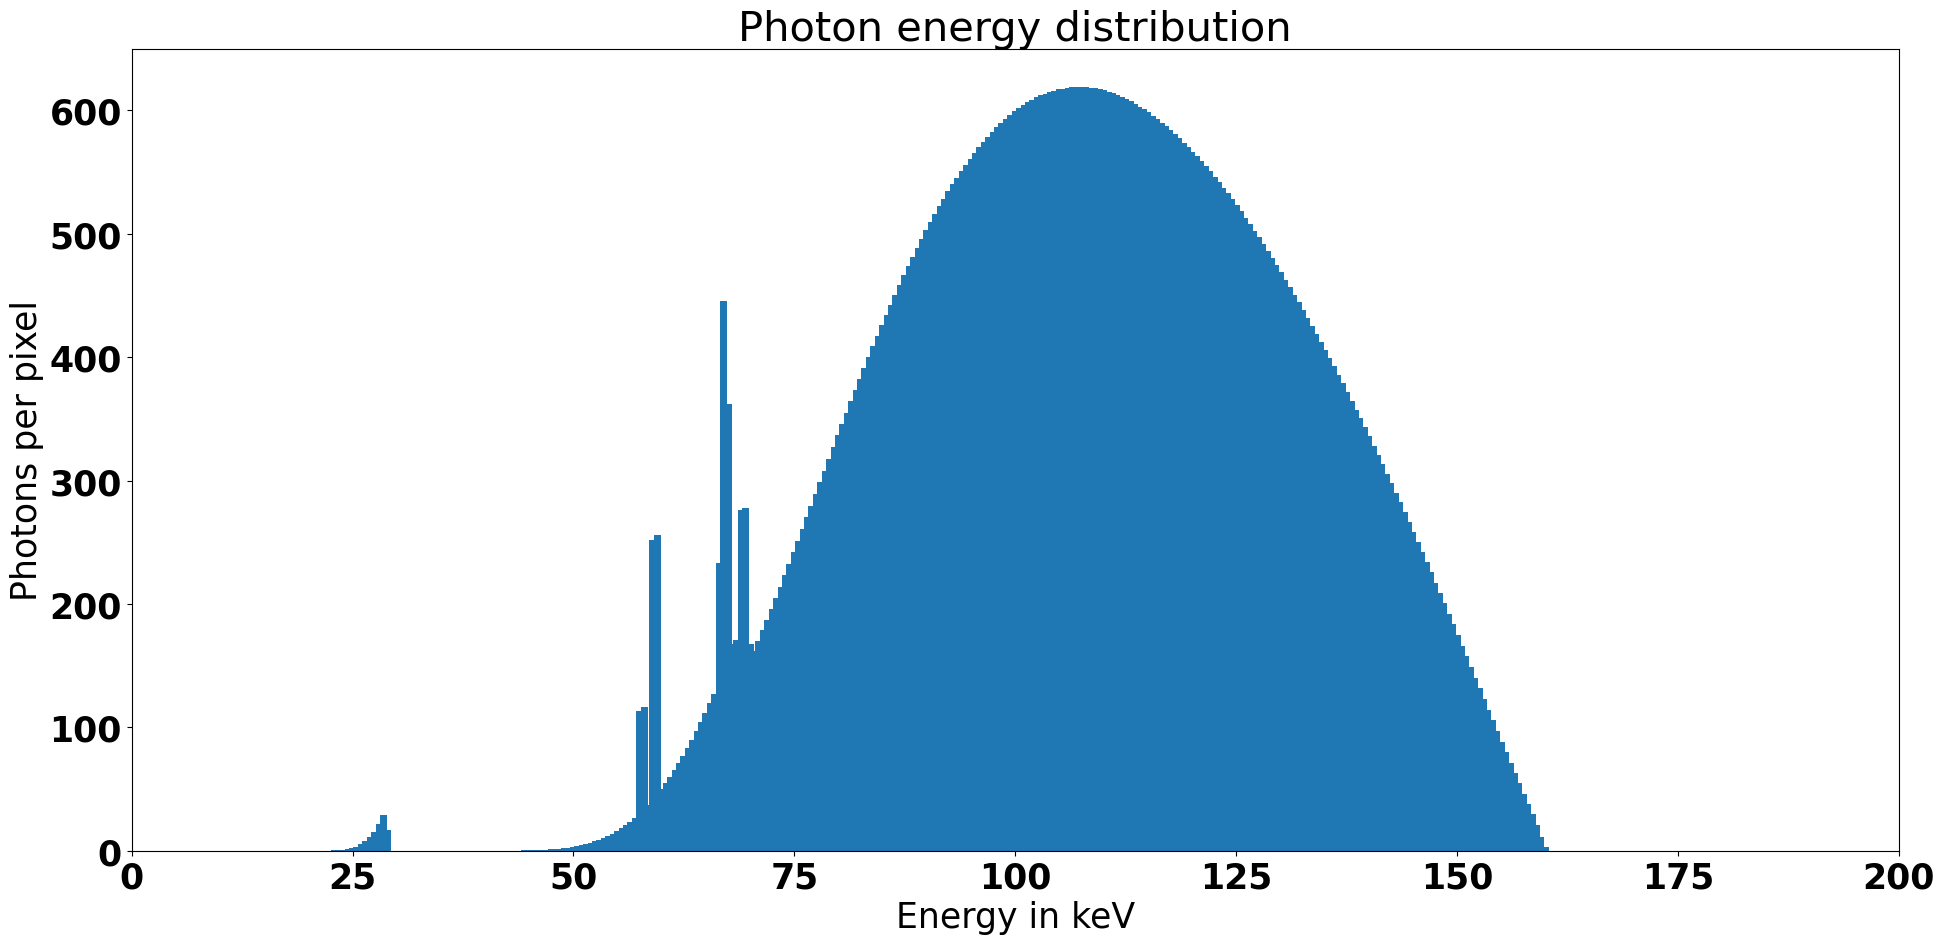

In [9]:
# Plot the beam spectrum
energy_bins = gvxr.getEnergyBins("keV")
photon_counts = gvxr.getPhotonCountEnergyBins()
plt.figure(figsize=(20,10))
plt.bar(energy_bins, photon_counts)
plt.xlabel('Energy in keV')
plt.ylabel('Photons per pixel')
plt.title('Photon energy distribution')
plt.xlim([0,200])
plt.tight_layout()

plt.savefig("../results/dragon/beam-spectrum.png", dpi=20)
plt.savefig("../results/dragon/beam-spectrum.pdf", dpi=600)

In [10]:
# Load the sample
json2gvxr.initSamples(verbose=0)

Fri Aug 16 13:09:03 2024 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/../../../../miniconda3/envs/gVXR-SPIE2024/lib/python3.10/site-packages/gvxrPython3/_gvxrPython3/welsh-dragon-small.stl	nb_faces:	457345	nb_vertices:	1372035	bounding_box (in cm):	(-4.47065, -74.9368, 23.5909)	(2.37482, -59.4256, 36.0343)


In [11]:
# Use k3d to perform the 3D visualisation
plot = visualise()
plot.display()

Output()

In [12]:
# Save the plot in an HTML file
if plot:
    with open('../results/dragon/snapshot.html','w') as fp:
        fp.write(plot.get_snapshot())

In [13]:
# Compute an X-ray image
x_ray_image = np.array(gvxr.computeXRayImage()).astype(np.single) / gvxr.getWhiteImage()

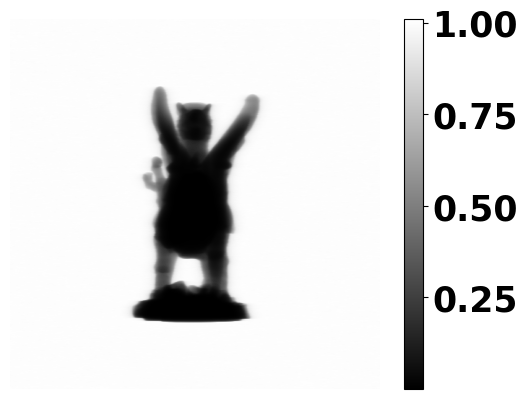

In [14]:
# Display the corresponding X-ray image
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar()
plt.axis('off');

In [15]:
# Change to a white background (it could be useful for putting screenshots in papers)
gvxr.setWindowBackGroundColour(1.0, 1.0, 1.0, -1);

In [16]:
# Interactive visualisation
# The user can rotate the 3D scene and zoom-in and -out in the visualisation window.
# It can be useful to rotate the visualisation of the 3D environment and zoom in/out
# to take the best posible screenshots

# - Keys are:
#     - Q/Escape: to quit the event loop (does not close the window)
#     - B: display/hide the X-ray beam
#     - W: display the polygon meshes in solid or wireframe
#     - N: display the X-ray image in negative or positive
#     - H: display/hide the X-ray detector
# - Mouse interactions:
#     - Zoom in/out: mouse wheel
#     - Rotation: Right mouse button down + move cursor```
# gvxr.renderLoop()

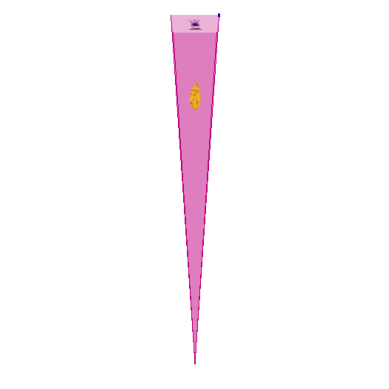

In [17]:
# Take and display a screenshot
gvxr.setZoom(2500);
gvxr.displayScene();
screenshot = gvxr.takeScreenshot();
plt.imshow(screenshot);
plt.axis('off');

## Simulate the CT acquisition and save the projections

In [18]:
# Simulate a CT scan acquisition
json2gvxr.initScan();

start = time.time();

angles = json2gvxr.doCTScan();

stop = time.time();
runtime, unit = getRuntime(start, stop);
print("Execution time:", "{0:0.2f}".format(runtime), unit);

Set up the CT Scan
Execution time: 9.93 sec


## Set the CT reconstruction parameters

In [19]:
# Create the JSON2gVXR reader by passing the filename
reader = JSON2gVXRDataReader(file_name=json_fname)

# Read in file, and return a numpy array containing the data
data_original = reader.read()

[512, 512]
[0.05, 0.05]


In [20]:
# Update the font size
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

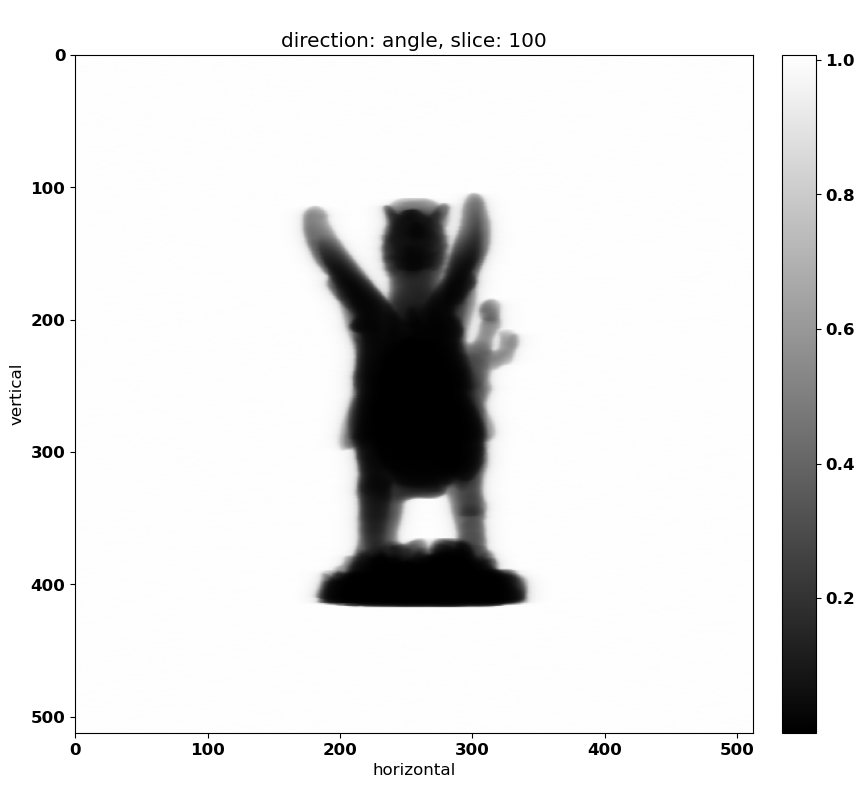

In [21]:
# Use show2D to visualise a projection
show2D(data_original, origin="upper-left")

In [22]:
# Interactive visualisation in Jupyter
islicer(data_original, origin="upper-left")

In [23]:
# Normalisation and linearisation
data_absorption = TransmissionAbsorptionConverter(white_level=data_original.max(), min_intensity=1e-9)(data_original)

In [24]:
# Create the CIL geoemtry
geometry = data_absorption.geometry

In [25]:
# Shutdown the simulation engine
gvxr.terminate()

Fri Aug 16 13:09:18 2024 ---- Destroy all the windows
Fri Aug 16 13:09:18 2024 ---- Destroy window 0(0x559ee2e25420)
Fri Aug 16 13:09:18 2024 ---- Release all the memory


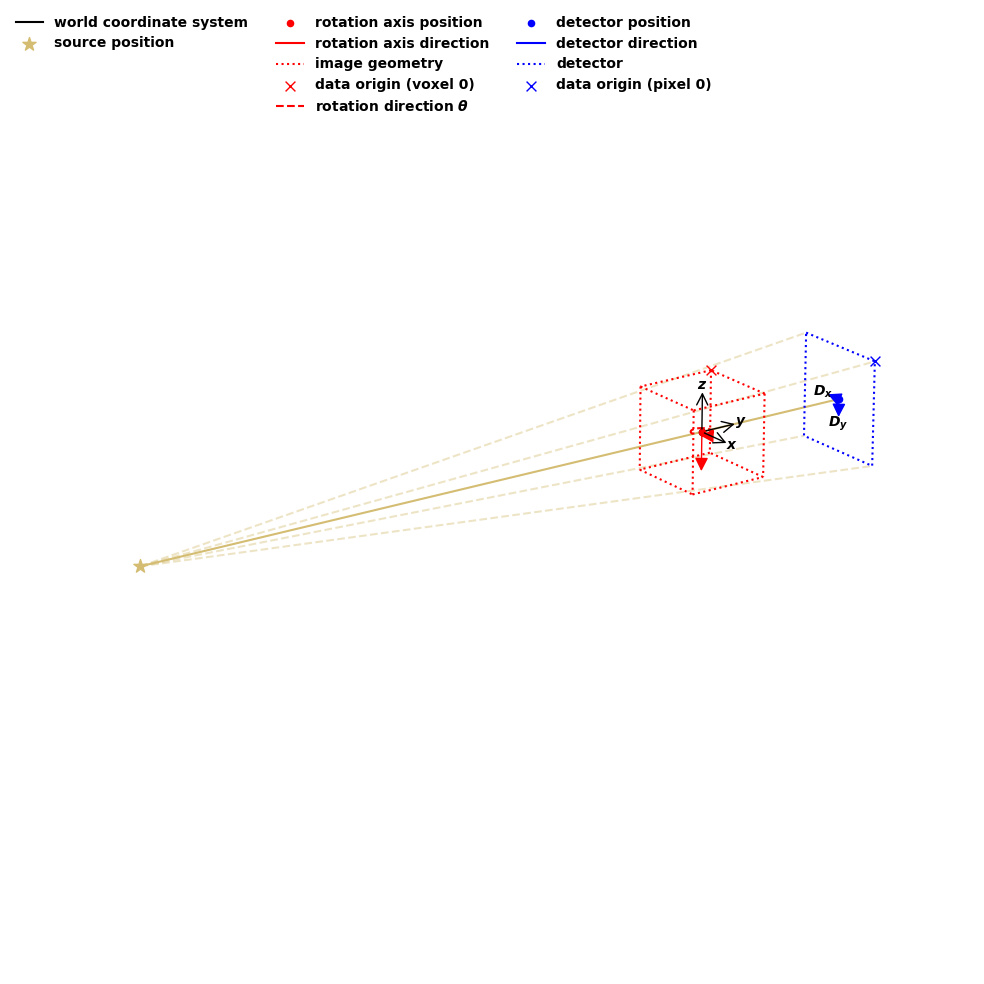

Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/geometry.png
Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/geometry.pdf


<Figure size 640x480 with 0 Axes>

In [26]:
# Display and save the geometry, does it look like a feasible CT scan set up?
fig = show_geometry(geometry);
fig.save("../results/dragon/geometry.png");
fig.save("../results/dragon/geometry.pdf");

In [27]:
# Print details of the scanning geometry
print(geometry)

3D Cone-beam tomography
System configuration:
	Source position: [   0., -150.,    0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [ 0., 40.,  0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [512 512]
	Pixel size: [0.05 0.05]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 200
	Angles 0-9 in degrees: [ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2]
	Angles 190-199 in degrees: [342. , 343.8, 345.6, 347.4, 349.2, 351. , 352.8, 354.6, 356.4, 358.2]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


In [28]:
# Prepare the data for the reconstruction
acquisition_data = AcquisitionData(data_absorption, deep_copy=False, geometry=geometry)
acquisition_data.reorder(order='tigre')
ig = acquisition_data.geometry.get_ImageGeometry()

In [29]:
# Print details of the reconstructed volume
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x512,y512,z512
voxel_size : x0.03947368421052632,y0.03947368421052632,z0.03947368421052632
center : x0,y0,z0



## Perform the CT reconstruction using the FDK algorithm and save the reconstructed volume

In [30]:
# Perform the FDK reconstruction
fdk =  FDK(acquisition_data, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 200
	vertical: 512
	horizontal: 512

Reconstruction Volume:
	vertical: 512
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



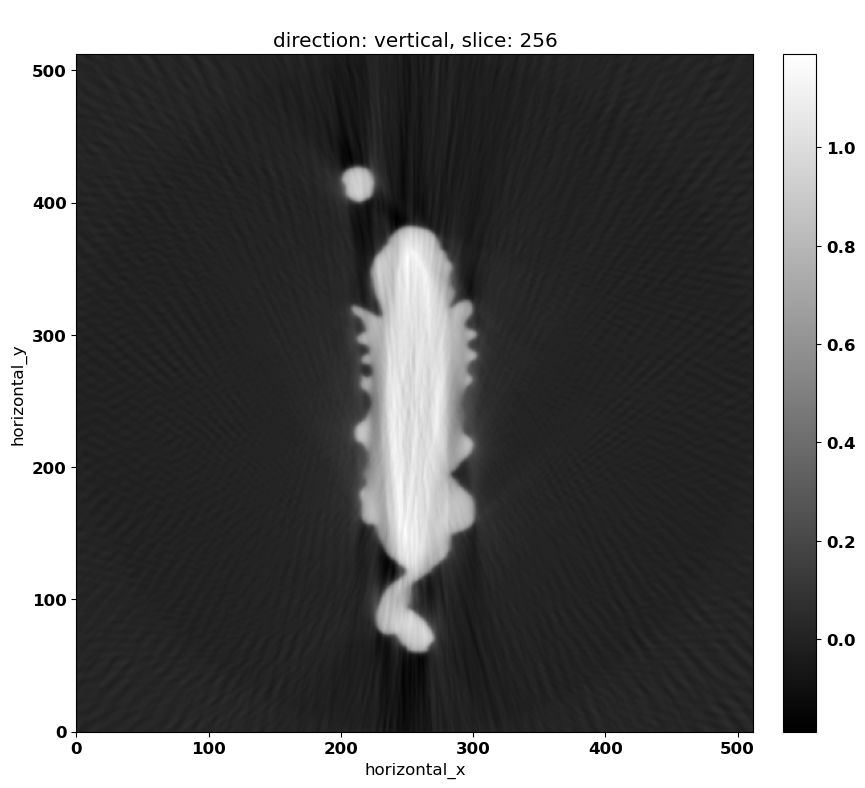

In [31]:
# Show a 2D slice
show2D(recon)

In [32]:
# Interactive visualisation in Jupyter
islicer(recon)

In [33]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon, file_name=os.path.join("../results/dragon/recons-FDK", "out")).write()

## Perform the CT reconstruction using the SIRT algorithm and save the reconstructed volume

In [34]:
# Create projection operator using Astra-Toolbox.
acquisition_data.reorder(order='astra')
A = ProjectionOperator(ig, geometry, "gpu")

In [35]:
# Create the initial guess
x0 = ig.allocate()

# non-zero constraint
constraint = IndicatorBox(lower=0)

# Instantiate the reconstruction algorithm
sirt = SIRT(initial=x0, operator=A, data=acquisition_data, constraint=constraint, max_iteration=500)

In [36]:
# Perform 500 iterations
sirt.update_objective_interval = 50
sirt.run(500)

recon_sirt_noisy = sirt.solution

  0%|          | 0/500 [00:00<?, ?it/s]

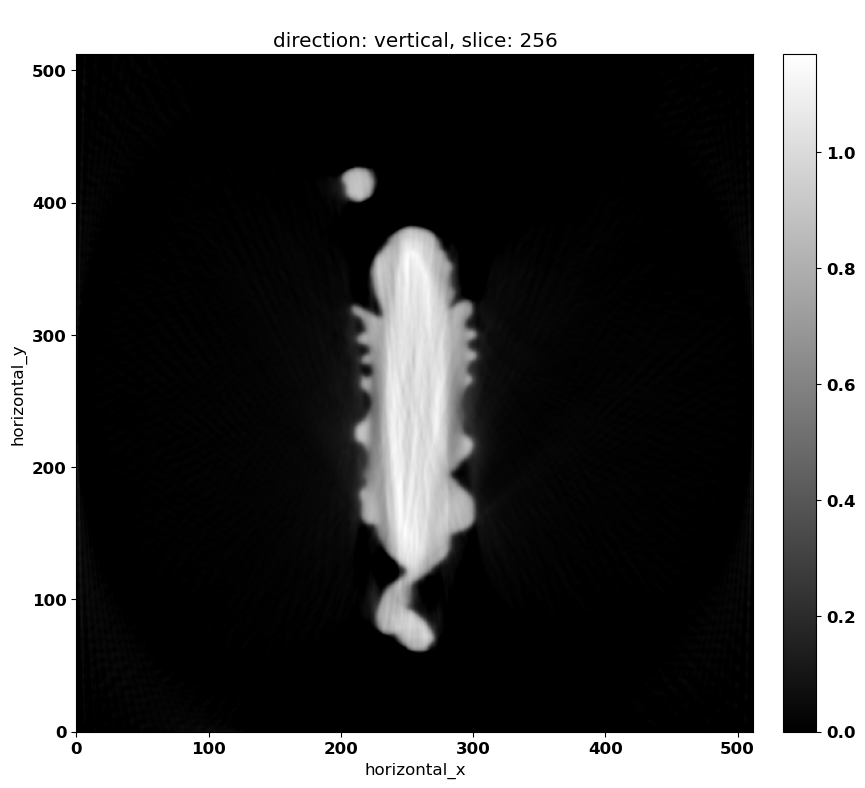

In [37]:
# Show a 2D slice
show2D(recon_sirt_noisy)

In [38]:
# Interactive visualisation in Jupyter
islicer(recon_sirt_noisy)

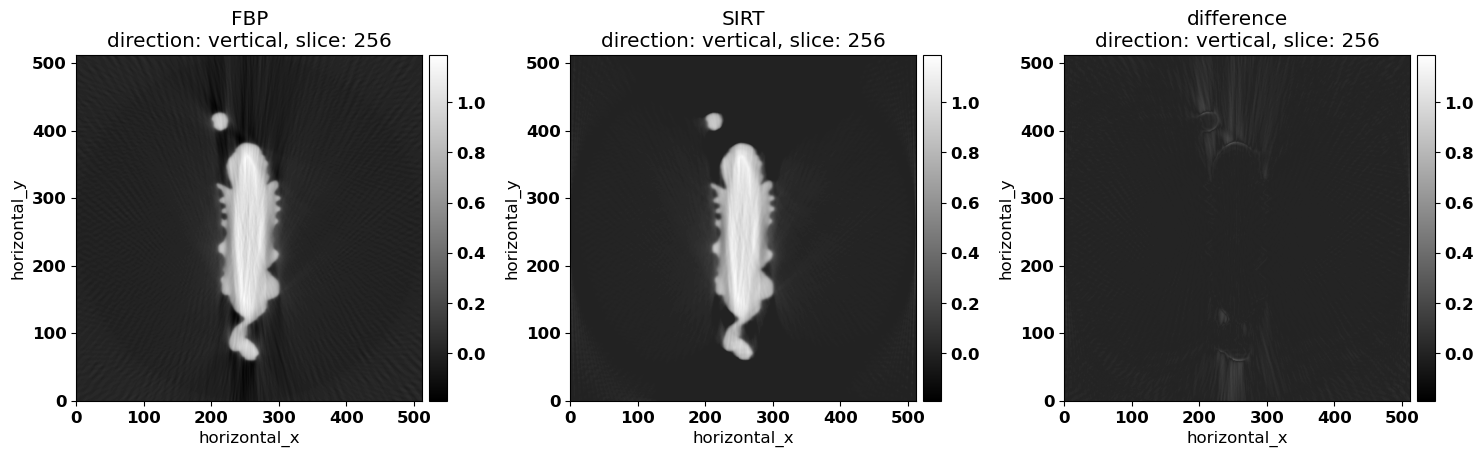

Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/comparison.png
Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/comparison.pdf


<Figure size 640x480 with 0 Axes>

In [39]:
# Show a comparison
fig = show2D([recon, recon_sirt_noisy, (recon-recon_sirt_noisy).abs()], \
       ['FBP', 'SIRT', 'difference'], \
       cmap="gray", num_cols=3, size=(15,15), origin='bottom-left', fix_range=True);

fig.save("../results/dragon/comparison.png", dpi=300)
fig.save("../results/dragon/comparison.pdf", dpi=600)

In [40]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon_sirt_noisy, file_name=os.path.join("../results/dragon/recons-SIRT", "out")).write()